In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
                
from sklearn.preprocessing import LabelEncoder
from src.wrapped import Wrapped
from src.analysesV02 import Analytics
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Importando dados para treinamento

In [2]:
ac = Analytics()

wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

In [3]:
# dataframe
df = wp.load_data('df_instrumentos_features_selecionadas')
df = df.query("instrumento != 'voice' & instrumento != 'synthesizer'")

# dataframes por instrumentos
inst_corda    = ["cello", "guitar", "violin", "bass", "banjo", "mandolin", "ukulele"]
inst_percusao = ["mallet_percussion", "drums", "cymbals"]
inst_sopro    = ["clarinet", "trombone", "flute", "trumpet", "saxophone"]
inst_aerofone = ["accordion", "organ", "piano"] 

df_inst_aerofone = df[df['instrumento'].isin(inst_aerofone)]
df_inst_sopro    = df[df['instrumento'].isin(inst_sopro)]
df_inst_corda    = df[df['instrumento'].isin(inst_corda)]
df_inst_percusao = df[df['instrumento'].isin(inst_percusao)]

# import resultados modelos 
aerofone_xgb = wp.load_data('resultados_parametros_aerofone_XGBoost')
sopro_xgb = wp.load_data('resultados_parametros_sopro_XGBoost')
percusao_xgb = wp.load_data('resultados_parametros_percusao_XGBoost')

aerofone_histGB = wp.load_data('resultados_parametros_aerofone_histGB')
sopro_histGB = wp.load_data('resultados_parametros_sopro_histGB')
percusao_histGB = wp.load_data('resultados_parametros_percusao_histGB')

# Pre-processamento

- Label Encoder

In [88]:
le = LabelEncoder()

df_inst_aerofone['labels'] = le.fit_transform(df_inst_aerofone.instrumento)
df_inst_sopro['labels']    = le.fit_transform(df_inst_sopro.instrumento)
df_inst_corda['labels']    = le.fit_transform(df_inst_corda.instrumento)
df_inst_percusao['labels'] = le.fit_transform(df_inst_percusao.instrumento)

# Analise de Anomalias

- Detecção de outilers

In [7]:
knn_pred_df = ac.detected_outilers_knn(dataframe=df, neighbors=5, algorithm="auto", metric="euclidean")
knn_pred_aerofone = ac.detected_outilers_knn(dataframe=df_inst_aerofone, neighbors=5, algorithm="auto", metric="euclidean")
knn_pred_sopro = ac.detected_outilers_knn(dataframe=df_inst_sopro, neighbors=5, algorithm="auto", metric="euclidean")
knn_pred_percusao = ac.detected_outilers_knn(dataframe=df_inst_percusao, neighbors=5, algorithm="auto", metric="euclidean")
knn_pred_corda    = ac.detected_outilers_knn(dataframe=df_inst_corda, neighbors=5, algorithm="auto", metric="euclidean")

preds_inst = {
    'Base Geral': knn_pred_df,
    'Aerofone': knn_pred_aerofone,
    'Sopro': knn_pred_sopro,
    'Percusao': knn_pred_percusao,
    'Corda': knn_pred_corda
}

- Numeros de outilers e inlers

In [18]:
for inst in preds_inst.keys():
    print(f'{inst} -> {np.unique(preds_inst[inst]["predictions"], return_counts=True)}')

Base Geral -> (array([0, 1]), array([7018,  631]))
Aerofone -> (array([0, 1]), array([1605,  145]))
Sopro -> (array([0, 1]), array([1472,  137]))
Percusao -> (array([0, 1]), array([1429,  129]))
Corda -> (array([0, 1]), array([2511,  221]))


- Grafíco de Anomalias TSNE

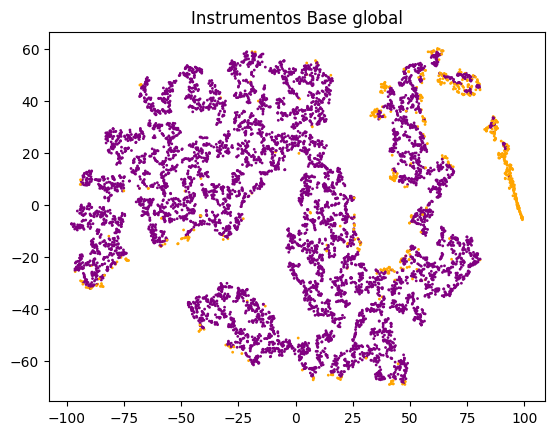

In [25]:
ac.graphic_anomalies(df, knn_pred_df["predictions"],'Instrumentos Base global')

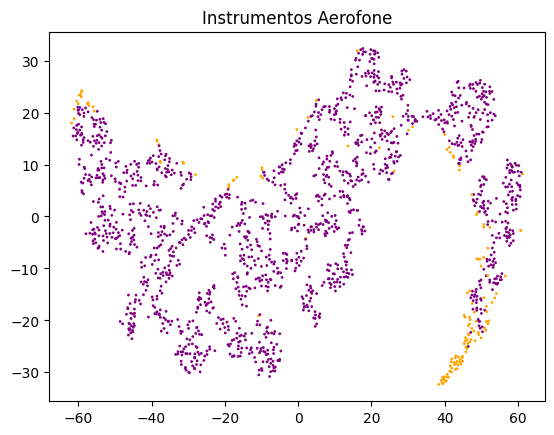

In [26]:
ac.graphic_anomalies(df_inst_aerofone, knn_pred_aerofone["predictions"],'Instrumentos Aerofone')

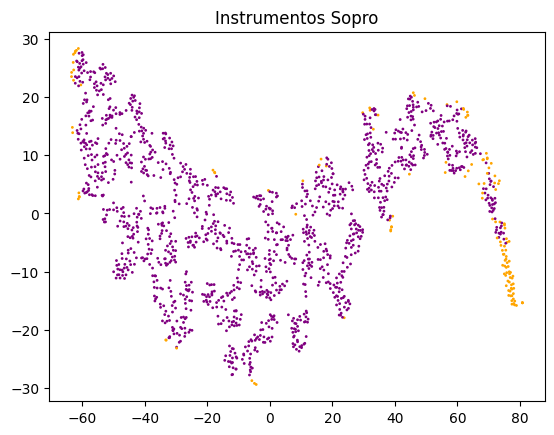

In [27]:
ac.graphic_anomalies(df_inst_sopro, knn_pred_sopro["predictions"],'Instrumentos Sopro')

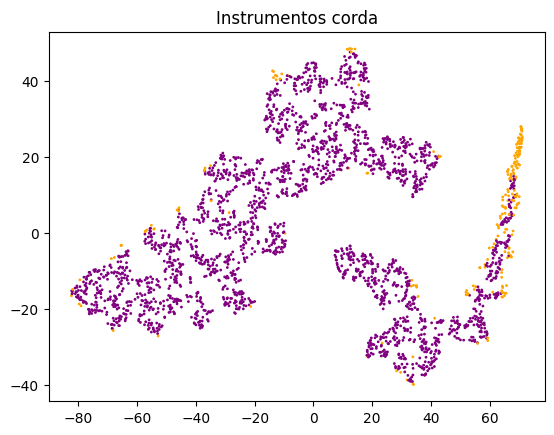

In [28]:
ac.graphic_anomalies(df_inst_corda, knn_pred_corda["predictions"],'Instrumentos corda')

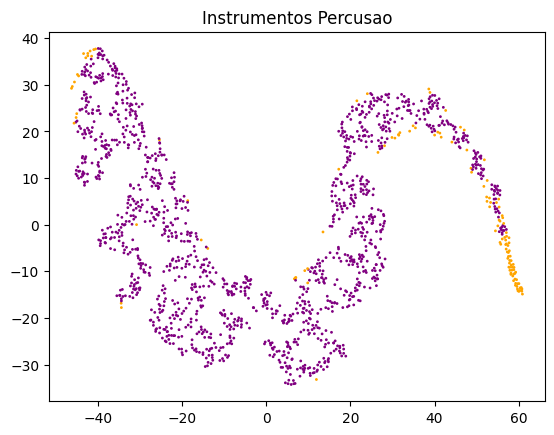

In [29]:
ac.graphic_anomalies(df_inst_percusao, knn_pred_percusao["predictions"],'Instrumentos Percusao')

- Outilers da base 

In [8]:
outilers_aerofone = ac.show_outilers(df_inst_aerofone, knn_pred_aerofone["predictions"])
outilers_sopro = ac.show_outilers(df_inst_sopro, knn_pred_sopro["predictions"])
outilers_percusao = ac.show_outilers(df_inst_percusao, knn_pred_percusao["predictions"])
outilers_corda = ac.show_outilers(df_inst_corda, knn_pred_corda["predictions"])
outilers_base_geral = ac.show_outilers(df, knn_pred_df["predictions"])

- Numero de Outilers por base

In [10]:
ac.table_outilers_inst(outilers_base_geral)

,nome,total_inst
0,flute,111
1,mallet_percussion,110
2,cymbals,76
3,drums,47
4,violin,45
5,bass,38
6,organ,33
7,guitar,31
8,accordion,29
9,ukulele,17


In [11]:
ac.table_outilers_inst(outilers_percusao)

,nome,total_inst
0,mallet_percussion,69
1,cymbals,37
2,drums,23


In [12]:
df_inst_percusao.shape

(1558, 47)

In [13]:
outilers_percusao.shape

(129, 47)

In [14]:
ac.table_outilers_inst(outilers_sopro)

,nome,total_inst
0,flute,91
1,clarinet,17
2,saxophone,15
3,trombone,7
4,trumpet,7


In [15]:
ac.table_outilers_inst(outilers_corda)

,nome,total_inst
0,violin,68
1,bass,40
2,banjo,30
3,guitar,28
4,mandolin,23
5,ukulele,23
6,cello,9


In [16]:
ac.table_outilers_inst(outilers_aerofone)

,nome,total_inst
0,accordion,77
1,organ,52
2,piano,16


- Plot de outilers

In [17]:
outilers_base_geral

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,file_name
28,0.177880,0.099179,0.446227,0.186154,0.310970,0.289374,0.480033,0.271526,0.262448,-113.129501,...,3006.696138,3178.625677,1.504104,5658.636007,-64.840324,-79.991013,0.225914,49936,accordion,011547_157440.ogg
46,0.001389,0.058207,0.307783,0.359920,0.321503,0.340189,0.230577,0.230887,0.267941,-335.472443,...,3364.332940,3317.306522,1.480623,6072.413242,-37.332355,-79.453758,0.249911,55267,accordion,019554_199680.ogg
78,0.092169,0.133666,0.193358,0.281352,0.774958,0.293572,0.316613,0.302946,0.372028,-121.544807,...,2537.886103,2105.938025,1.162251,3689.097337,-49.523079,-69.013954,0.146228,32336,accordion,028377_42240.ogg
101,-0.083369,0.002492,0.365614,0.188457,0.210712,0.340728,0.218881,0.389993,0.138017,-118.916946,...,2898.294706,2495.492458,1.521361,4334.344015,-64.275818,-79.999847,0.203175,44935,accordion,035590_49920.ogg
102,0.304000,0.122806,0.350294,0.218089,0.486672,0.214657,0.331902,0.073321,0.085603,-238.317444,...,3110.390356,3408.975053,1.338741,6270.983349,-78.413834,-80.000000,0.231030,51151,accordion,035929_145920.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,0.073335,-0.133666,0.198421,0.638581,0.470585,0.183783,0.221596,0.165835,0.097834,-214.820984,...,3205.624534,2709.861006,1.258017,4788.439800,-52.124996,-68.260452,0.173822,38418,violin,146573_142080.ogg
7999,0.188614,-0.123051,0.435805,0.078954,0.048469,0.095815,0.166382,0.088318,0.250419,-390.158630,...,2069.443752,1772.864514,1.268380,2945.977004,-76.595161,-80.000000,0.126178,27872,violin,147132_0.ogg
8017,0.096697,-0.279816,0.159033,0.078111,0.079078,0.180735,0.292732,0.125269,0.363708,-115.140617,...,3348.078759,2277.244488,1.186836,3779.127109,-50.537724,-80.000000,0.143759,31806,violin,151281_61440.ogg
8020,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,-324.705627,...,3383.563150,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,154469_318720.ogg


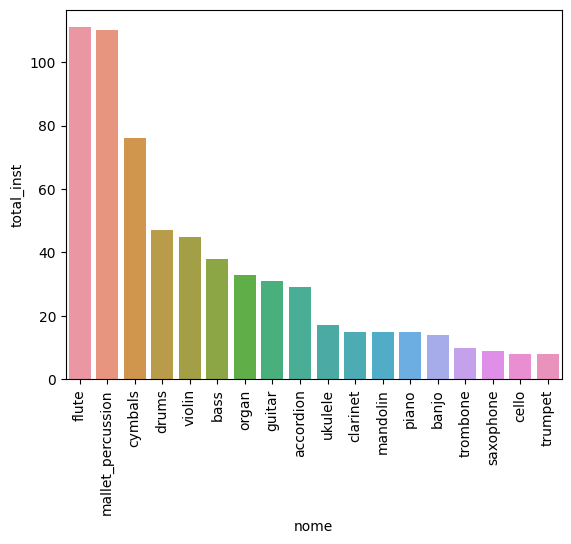

In [18]:
ac.plot_outilers_inst(outilers_base_geral)

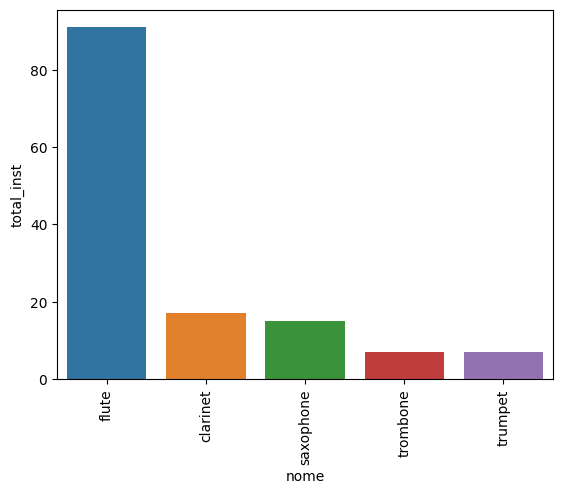

In [23]:
ac.plot_outilers_inst(outilers_sopro)

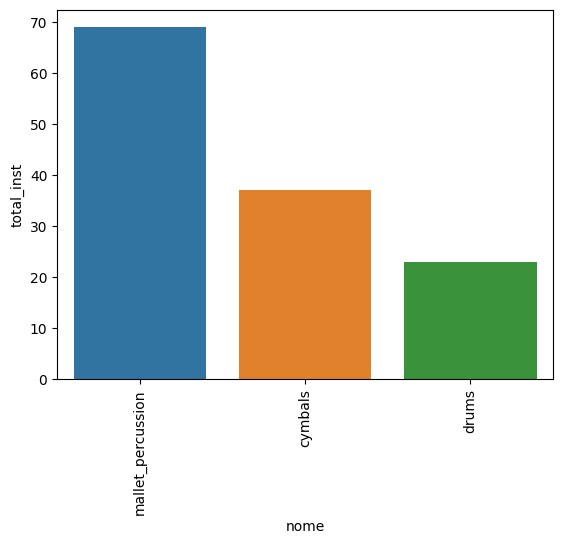

In [24]:
ac.plot_outilers_inst(outilers_percusao)

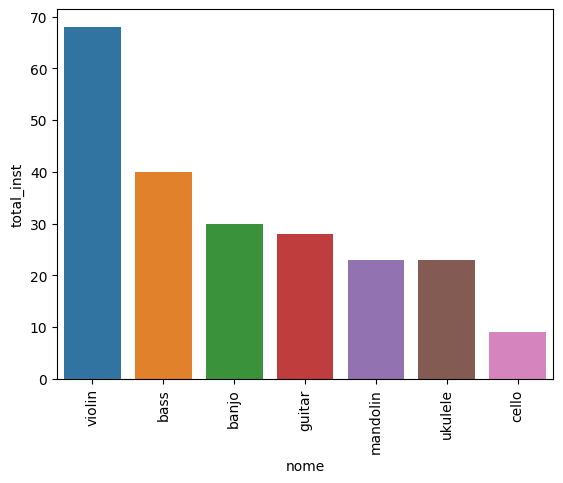

In [25]:
ac.plot_outilers_inst(outilers_corda)

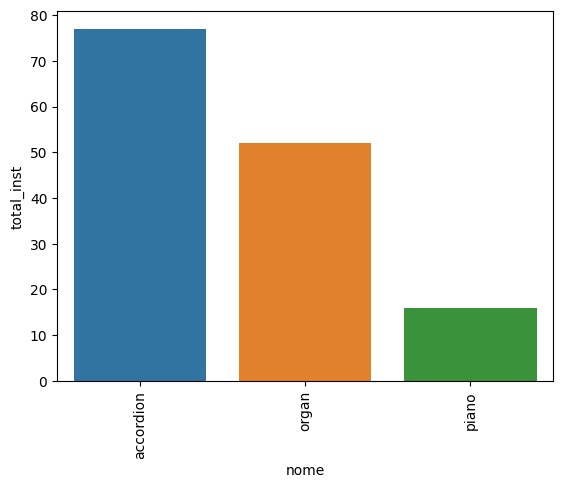

In [26]:
ac.plot_outilers_inst(outilers_aerofone)